In [1]:
# 1. 나눔 폰트 설치
!apt-get -qq install -y fonts-nanum

# 2. 나눔 폰트 경로 지정 및 적용
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 나눔고딕 경로
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

mpl.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
# 데이터 불러오기

import pandas as pd

# 문자열로 불러오기 (부작용발생일자 포맷 유지)
df_raw = pd.read_csv("/content/drive/MyDrive/anl_data.csv", dtype=str)

# 날짜 파싱
df = df_raw.copy()
df['약복용시작일'] = pd.to_datetime(df['약복용시작일'], errors='coerce')
df['약복용종료일'] = pd.to_datetime(df['약복용종료일'], errors='coerce')
df['부작용발생일자'] = pd.to_datetime(df['부작용발생일자'], format='%Y%m%d', errors='coerce')  # 정확한 포맷 지정


In [3]:
# 데이터 전처리

# 이벤트 여부
df['event'] = df['부작용발생일자'].notnull().astype(int)
df['중도절단여부'] = 1 - df['event']

# 종료일자 설정
최종관측일 = pd.to_datetime("2025-03-31")
df['종료일자'] = df.apply(
    lambda row: row['부작용발생일자'] if row['event'] == 1
    else row['약복용종료일'] if pd.notnull(row['약복용종료일'])
    else 최종관측일,
    axis=1
)

# 생존시간 계산 (일 → 주 단위)
df['생존시간'] = (df['종료일자'] - df['약복용시작일']).dt.days
df = df[df['생존시간'] >= 0]
df['생존주'] = df['생존시간'] // 7

# 분석용 데이터 구성
df_analysis = df[['고유번호', '약물종류', '생존주', 'event']]


In [4]:
import warnings
import logging

# font 관련 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=721a884a38352ba5592517e445c8f31b7f09b991eb11006bfeaa37072be55fb6
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


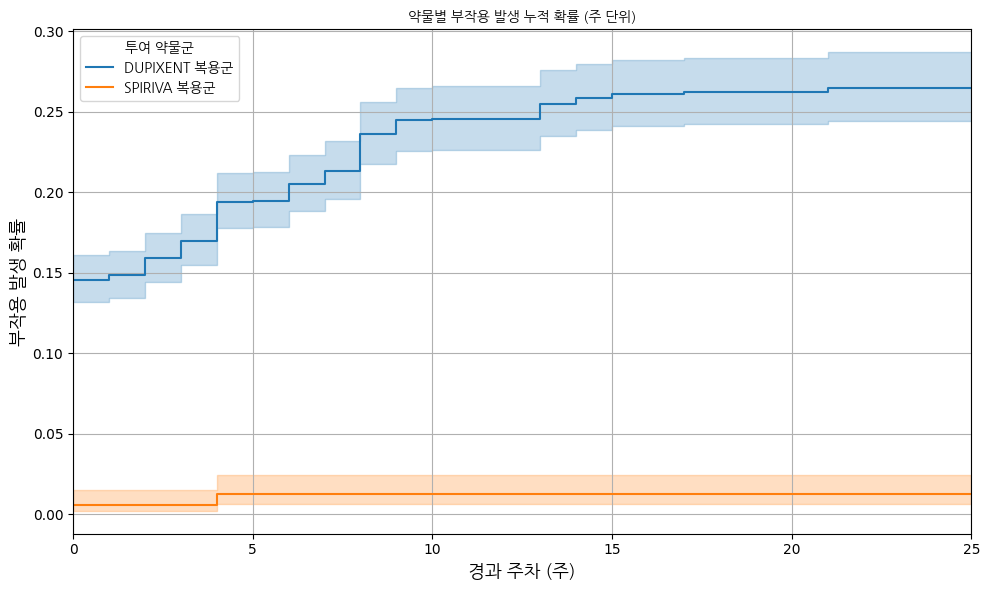

In [6]:
# 생존분석 실시(1)
!pip install lifelines
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import warnings
import logging

# 1. 경고 무시 설정
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 2. 그래프 출력
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for 약물 in ['DUPIXENT', 'SPIRIVA']:
    그룹 = df_analysis['약물종류'] == 약물
    kmf.fit(df_analysis[그룹]['생존주'], event_observed=df_analysis[그룹]['event'], label=f'{약물} 복용군')
    kmf.plot_cumulative_density(label=f'{약물} 복용군')

plt.title('약물별 부작용 발생 누적 확률 (주 단위)', fontsize=16, fontproperties=font_prop)
plt.xlabel('경과 주차 (주)', fontsize=13, fontproperties=font_prop)
plt.ylabel('부작용 발생 확률', fontsize=13, fontproperties=font_prop)
plt.xlim(0, 25)
plt.grid(True)
plt.legend(prop=font_prop, title='투여 약물군', title_fontproperties=font_prop)
plt.tight_layout()
plt.show()


In [7]:
# log-rank 검정

from lifelines.statistics import logrank_test

# 그룹별 데이터 분리
group1 = df_analysis[df_analysis['약물종류'] == 'DUPIXENT']
group2 = df_analysis[df_analysis['약물종류'] == 'SPIRIVA']

results = logrank_test(
    group1['생존주'], group2['생존주'],
    event_observed_A=group1['event'], event_observed_B=group2['event']
)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         171.59 <0.005    127.82

In [8]:
# 빈도분석

# 1. 카운트 (빈도수)
count_table = df_analysis.groupby('약물종류')['event'].value_counts().unstack().fillna(0).astype(int)

# 2. 비율 (normalize=True, 소수점 둘째자리)
ratio_table = df_analysis.groupby('약물종류')['event'].value_counts(normalize=True).unstack().fillna(0).round(2)

# 3. 합계 계산
total = count_table.sum(axis=1)

# 4. 카운트 + 비율 병합
summary_table = pd.DataFrame()
summary_table['부작용 없음 (0)'] = count_table[0].astype(str) + ' (' + (ratio_table[0]*100).astype(str) + '%)'
summary_table['부작용 있음 (1)'] = count_table[1].astype(str) + ' (' + (ratio_table[1]*100).astype(str) + '%)'
summary_table['총합'] = total

# 5. 인덱스 이름 설정
summary_table.index.name = '약물종류'

summary_table


,부작용 없음 (0),부작용 있음 (1),총합
약물종류,,,
DUPIXENT,1716 (77.0%),500 (23.0%),2216
SPIRIVA,688 (99.0%),8 (1.0%),696


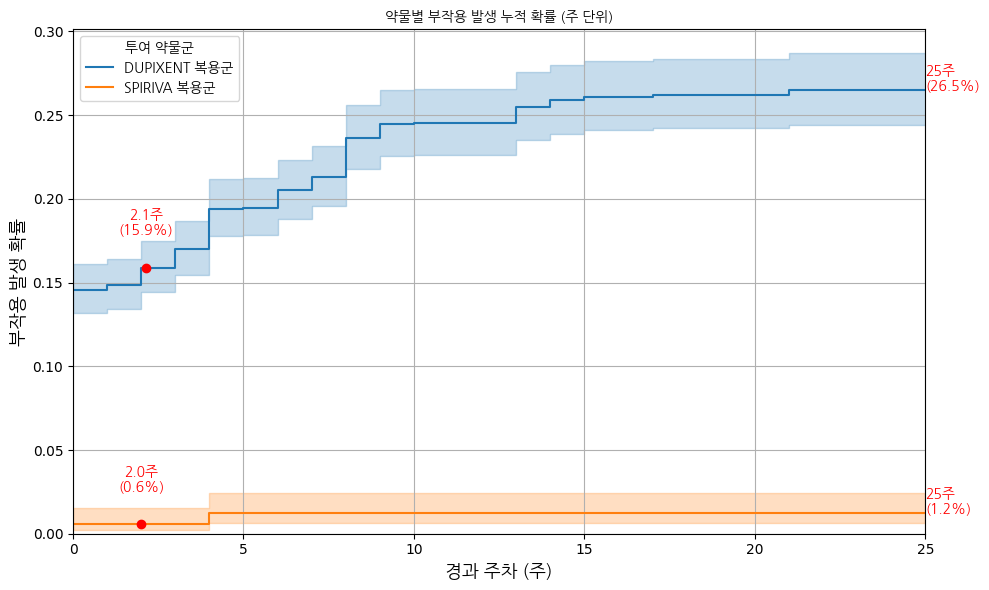

In [12]:
# 생존분석 실시(2) - 평균점 추가
!pip install lifelines

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import warnings
import logging
import matplotlib.font_manager as fm

# 1. 경고 무시
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 2. 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 3. 그래프 생성
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for 약물 in ['DUPIXENT', 'SPIRIVA']:
    그룹 = df_analysis['약물종류'] == 약물
    T = df_analysis[그룹]['생존주']
    E = df_analysis[그룹]['event']

    kmf.fit(T, event_observed=E, label=f'{약물} 복용군')
    ax = kmf.plot_cumulative_density(label=f'{약물} 복용군')

    # 3-1. 평균 생존주 기준 빨간 점
    평균주 = T[E == 1].mean()
    누적확률_평균 = kmf.cumulative_density_at_times(평균주).values[0]
    plt.plot(평균주, 누적확률_평균, 'ro')
    plt.text(평균주, 누적확률_평균 + 0.02,
             f'{평균주:.1f}주\n({누적확률_평균*100:.1f}%)',
             color='red', ha='center', fontsize=10, fontproperties=font_prop)

    # 3-2. 마지막주 누적 확률 (25주 기준 고정)
    마지막주 = 25
    누적확률_최종 = kmf.cumulative_density_at_times(마지막주).values[0]

    # 위치: 오른쪽 바깥으로 텍스트 정렬
    plt.text(마지막주, 누적확률_최종,
             f'{마지막주}주\n({누적확률_최종*100:.1f}%)',
             color='red', ha='left', fontsize=10, fontproperties=font_prop)

# 4. 시각화 세부 설정
plt.title('약물별 부작용 발생 누적 확률 (주 단위)', fontsize=16, fontproperties=font_prop)
plt.xlabel('경과 주차 (주)', fontsize=13, fontproperties=font_prop)
plt.ylabel('부작용 발생 확률', fontsize=13, fontproperties=font_prop)
plt.xlim(0, 25)
plt.ylim(0, None)
plt.grid(True)
plt.legend(prop=font_prop, title='투여 약물군', title_fontproperties=font_prop)
plt.tight_layout()
plt.show()
